### Bayesian Statistics



**Problem:** A railroad numbers its locomotives in order 1..N.

One day you see a locomotive with the number 60. Estimate how many loco-motives the railroad has.


**Possible Solution:** The interesting thing about above question is that it initially seems that we don’t have enough information to come up with any sort of answer. However, we can get an estimate if we come up with a prior to work with.

The simplest prior is to assume that there’s one railroad operator with between say 1 and 1000 railroads with an equal probability of each size.

We can then write similar code as with the dice problem to update the prior based on the trains we’ve seen.

First we’ll create a data frame which captures the product of ‘number of locomotives’ and the observations of locomotives that we’ve seen (in this case we’ve only seen one locomotive with number ’60’:)

Problem is taken from:[www.markhneedham.com](http://www.markhneedham.com/blog/2015/04/24/r-think-bayes-locomotive-problem-posterior-probabilities-for-different-priors/) 

In [14]:
library(dplyr)

In [15]:
possibleValues = 1:1000
observations = c(60)

In [16]:
l = list(value = possibleValues, observation = observations)

In [17]:
df = expand.grid(l)
 
df %>% tail()

,value,observation
995,995,60
996,996,60
997,997,60
998,998,60
999,999,60
1000,1000,60


Next we want to add a column which represents the probability that the observed locomotive could have come from a particular fleet. If the number of railroads is less than 60 then we have a 0 probability, otherwise we have 1 / numberOfRailroadsInFleet:

In [25]:
prior = 1  / length(possibleValues)
prior

df = df %>% mutate(score = ifelse(value < observation, 0, 1/value))

[1] 0.001

In [44]:
df %>% sample_n(10)

,value,observation,score
369,3.690000e+02,6.000000e+01,2.710027e-03
760,7.600000e+02,6.000000e+01,1.315789e-03
305,3.050000e+02,6.000000e+01,3.278689e-03
5,5,60,0
413,4.130000e+02,6.000000e+01,2.421308e-03
976,9.76000e+02,6.00000e+01,1.02459e-03
650,6.500000e+02,6.000000e+01,1.538462e-03
826,8.260000e+02,6.000000e+01,1.210654e-03
436,4.360000e+02,6.000000e+01,2.293578e-03
710,7.100000e+02,6.000000e+01,1.408451e-03


To find the probability of each fleet size we write the following code:

In [52]:
df[115,]

,value,observation,score
115,1.150000e+02,6.000000e+01,8.695652e-03


In [34]:
weightedDf = df %>% 
  group_by(value) %>% 
  summarise(aggScore = prior * prod(score)) %>% #prod returns the product of all the values present in its arguments.
  ungroup() %>%
  mutate(weighted = aggScore / sum(aggScore))

In [43]:
weightedDf %>% sample_n(10)

,value,aggScore,weighted
1,1.150000e+02,8.695652e-06,3.081088e-03
2,3.910000e+02,2.557545e-06,9.062022e-04
3,1.540000e+02,6.493506e-06,2.300812e-03
4,5.100000e+02,1.960784e-06,6.947550e-04
5,9.720000e+02,1.028807e-06,3.645320e-04
6,8.250000e+02,1.212121e-06,4.294849e-04
7,5.940000e+02,1.683502e-06,5.965069e-04
8,2.510000e+02,3.984064e-06,1.411654e-03
9,5.820000e+02,1.718213e-06,6.088060e-04
10,8.400000e+02,1.190476e-06,4.218156e-04


Let’s plot the data frame to see how the probability varies for each fleet size:

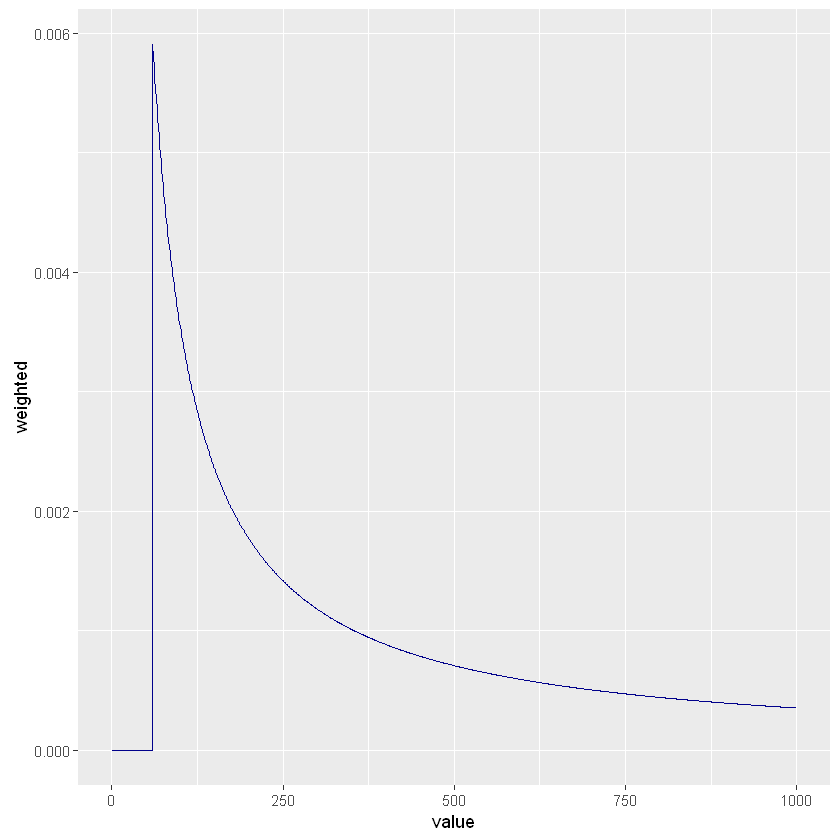

In [45]:
library(ggplot2)
ggplot(aes(x = value, y = weighted), data = weightedDf) + 
  geom_line(color="dark blue")

The most likely choice is a fleet size of 60 based on this diagram but an alternative would be to find the mean of the posterior which we can do like so:

In [46]:
weightedDf %>% mutate(mean = value * weighted) %>% select(mean) %>% sum()

[1] 333.4199

Now let’s create a function with all that code in so we can play around with some different priors and observations:

In [47]:
meanOfPosterior = function(values, observations) {
  l = list(value = values, observation = observations)   
  df = expand.grid(l) %>% mutate(score = ifelse(value < observation, 0, 1/value))
 
  prior = 1  / length(possibleValues)
  weightedDf = df %>% 
    group_by(value) %>% 
    summarise(aggScore = prior * prod(score)) %>%
    ungroup() %>%
    mutate(weighted = aggScore / sum(aggScore))
 
  return (weightedDf %>% mutate(mean = value * weighted) %>% select(mean) %>% sum()) 
}

If we update our observed railroads to have numbers 60, 30 and 90 we’d get the following means of posteriors assuming different priors:

In [48]:
meanOfPosterior(1:500, c(60, 30, 90))

meanOfPosterior(1:1000, c(60, 30, 90))

meanOfPosterior(1:2000, c(60, 30, 90))


[1] 151.8496

[1] 164.3056

[1] 171.3382

At the moment the function assumes that we always want to have a uniform prior i.e. every option has an equal opportunity of being chosen, but we might want to vary the prior to see how different assumptions influence the posterior.

We can refactor the function to take in values & priors instead of calculating the priors in the function:

In [49]:
meanOfPosterior = function(values, priors, observations) {
  priorDf = data.frame(value = values, prior = priors)
  l = list(value = priorDf$value, observation = observations)
 
  df = merge(expand.grid(l), priorDf, by.x = "value", by.y = "value") %>% 
    mutate(score = ifelse(value < observation, 0, 1 / value))
 
  df %>% 
    group_by(value) %>% 
    summarise(aggScore = max(prior) * prod(score)) %>%
    ungroup() %>%
    mutate(weighted = aggScore / sum(aggScore)) %>%
    mutate(mean = value * weighted) %>%
    select(mean) %>%
    sum()
}

In [50]:
meanOfPosterior(1:500,  1/length(1:500), c(60, 30, 90))

meanOfPosterior(1:1000, 1/length(1:1000), c(60, 30, 90))

meanOfPosterior(1:2000, 1/length(1:2000), c(60, 30, 90))

[1] 151.8496

[1] 164.3056

[1] 171.3382

Now if instead of a uniform prior let’s use a power law one where the assumption is that smaller fleets are more likely:



In [51]:
meanOfPosterior(1:500,  sapply(1:500,  function(x) x ** -1), c(60, 30, 90))

meanOfPosterior(1:1000, sapply(1:1000, function(x) x ** -1), c(60, 30, 90))

meanOfPosterior(1:2000, sapply(1:2000, function(x) x ** -1), c(60, 30, 90))

meanOfPosterior(1:5000, sapply(1:5000, function(x) x ** -1), c(60, 30, 90))

meanOfPosterior(1:10000, sapply(1:10000, function(x) x ** -1), c(60, 30, 90))

[1] 130.7085

[1] 133.2752

[1] 133.9975

[1] 134.212

[1] 134.2435

Now we get very similar posterior means which converge on 134 and so that’s our best prediction.